# **Hedonic Residual Score: Australian Property Investment Metric**

## Overview
This notebook implements an innovative real estate metric for Australian residential property investors:

**Hedonic Residual Score (HRS)**: Measures the difference between actual transaction prices and statistically predicted hedonic prices to identify undervalued properties and market inefficiencies.

## Why This Metric Matters for Investors

- **Market Inefficiency Detection**: Identifies properties selling below their statistically predicted value
- **Risk Assessment**: Helps avoid overpaying for properties with positive residuals (potentially overvalued)
- **Investment Alpha**: Provides quantitative insight beyond traditional price-to-rent or price-per-square metrics
- **Market Timing**: Systematic deviations can indicate broader market shifts

## Data Sources
- **transactions.parquet**: Property transactions with actual and hedonic prices
- **gnaf_prop.parquet**: Precise address and location data
- **Coverage**: North Sydney region (2002-2025), 5,576 transactions

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"Analysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully
Analysis completed on: 2025-10-17 20:41:37


In [2]:
# Load the property transaction data
print("Loading property transaction data...")
df = pd.read_parquet('transactions.parquet')

print(f"Dataset loaded: {len(df):,} transactions")
print(f"Date range: {df['date_sold'].min()} to {df['date_sold'].max()}")
print(f"Price range: ${df['price'].min():,} to ${df['price'].max():,}")

# Display first few rows and basic info
print("\nFirst 5 transactions:")
print(df[['date_sold', 'price', 'hedonic_price', 'suburb']].head())

print("\nDataset columns:")
print(df.columns.tolist())

Loading property transaction data...
Dataset loaded: 5,576 transactions
Date range: 2002-12-19 to 2025-07-03
Price range: $1,300.0 to $19,500,000.0

First 5 transactions:
     date_sold      price  hedonic_price       suburb
10  2002-12-19  2155000.0   1.950000e+06    ROSEVILLE
28  2002-12-19   925000.0   6.930000e+05   WILLOUGHBY
32  2002-12-19   450000.0   7.005405e+05   WILLOUGHBY
92  2002-12-20  2800000.0   1.400000e+06  NORTHBRIDGE
93  2002-12-20  1225000.0   1.885000e+06  NORTHBRIDGE

Dataset columns:
['gid', 'gnaf_pid', 'listing_source', 'state', 'street', 'suburb', 'bedrooms', 'bathrooms', 'garage_spaces', 'building_size', 'land_size', 'mb', 'sa1', 'poa', 'sal', 'typ', 'dat', 'price', 'zoning_appears_on_portals', 'market', 'hedonic_price', 'date_sold', 'display_price', 'source', 'property_type', 'yield']


In [3]:
# Calculate the Hedonic Residual Score
print("Calculating Hedonic Residual Score...")

# Remove any rows with missing price data
df_clean = df.dropna(subset=['price', 'hedonic_price'])

# Calculate residuals (actual - predicted)
df_clean['hedonic_residual'] = df_clean['price'] - df_clean['hedonic_price']

# Calculate percentage residual for better comparison across price ranges
df_clean['hedonic_residual_pct'] = (df_clean['hedonic_residual'] / df_clean['hedonic_price']) * 100

print(f"Analysis includes {len(df_clean):,} valid transactions")
print(f"Average residual: ${df_clean['hedonic_residual'].mean():,.0f}")
print(f"Average residual %: {df_clean['hedonic_residual_pct'].mean():.2f}%")

# Display summary statistics
print("\nResidual Statistics:")
print(df_clean[['hedonic_residual', 'hedonic_residual_pct']].describe())

Calculating Hedonic Residual Score...
Analysis includes 5,559 valid transactions
Average residual: $-66,758
Average residual %: -3.23%

Residual Statistics:
       hedonic_residual  hedonic_residual_pct
count      5.559000e+03           5559.000000
mean      -6.675822e+04             -3.233762
std        7.884228e+05             30.588622
min       -1.750000e+07            -50.000000
25%       -2.729741e+05            -22.418675
50%       -5.978196e+04             -5.679758
75%        1.016116e+05              8.762705
max        9.750000e+06            100.000000


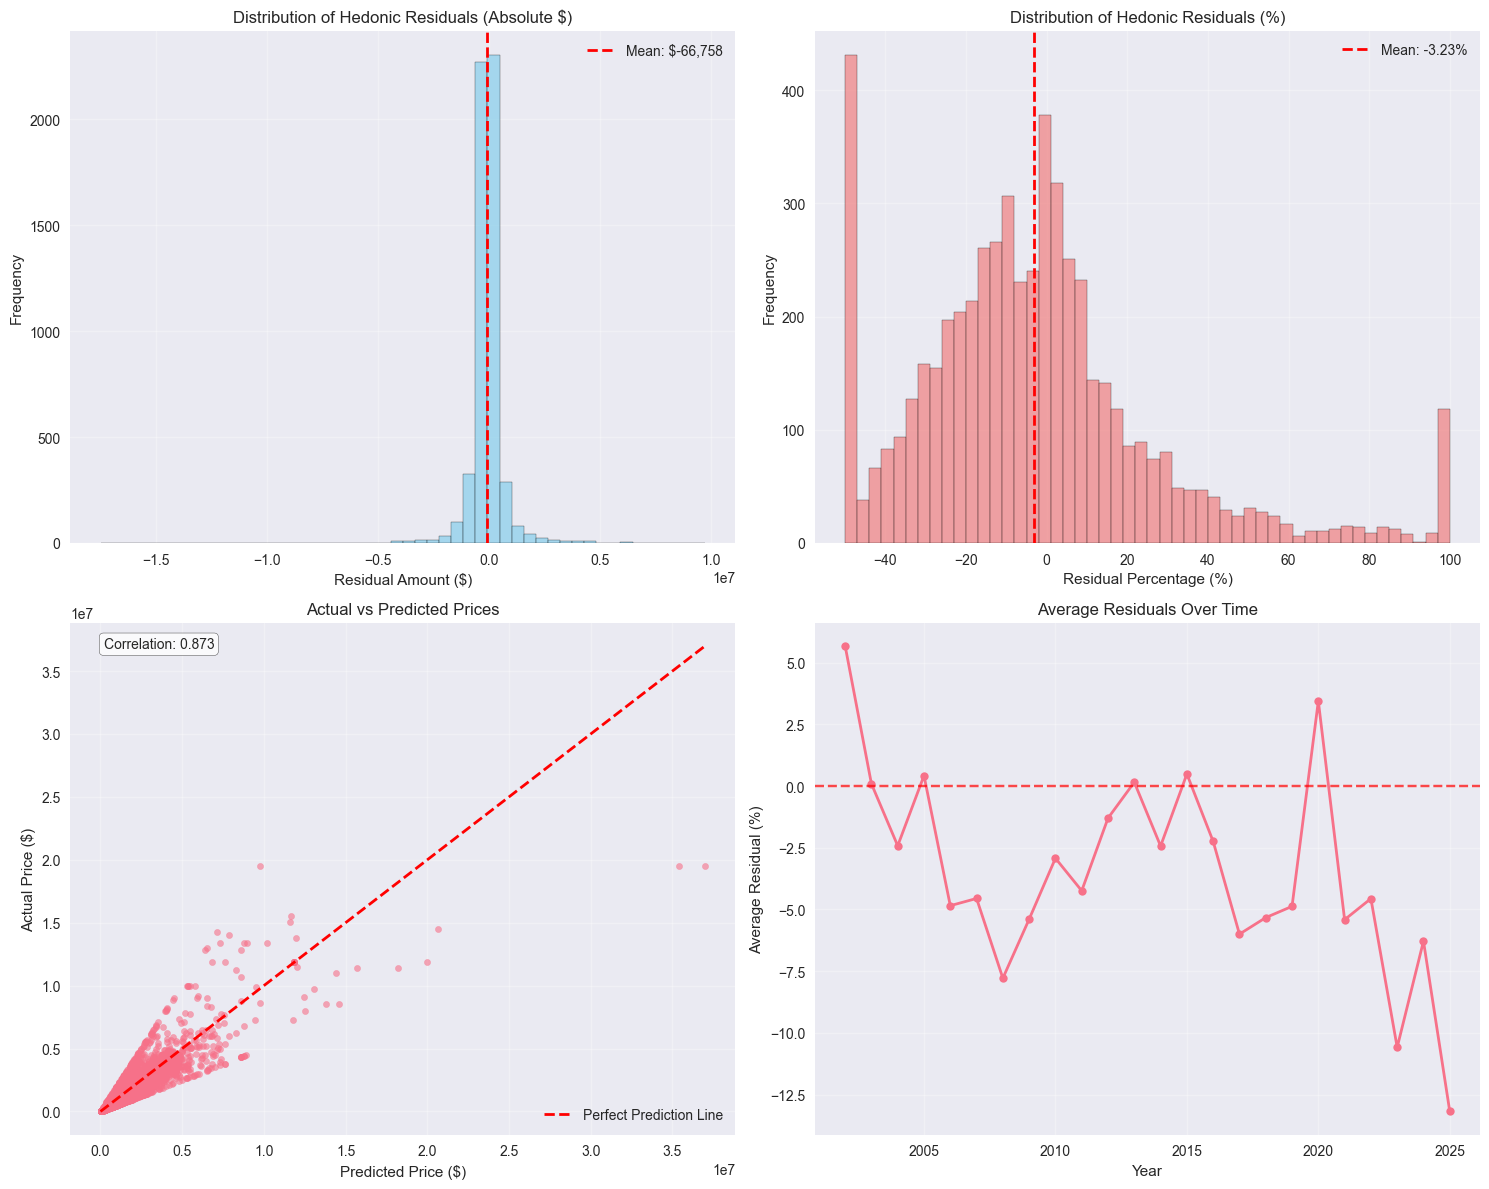

Visualization saved as 'hedonic_residual_analysis.png'


In [4]:
# Analyze the distribution of residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram of absolute residuals
axes[0,0].hist(df_clean['hedonic_residual'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df_clean['hedonic_residual'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df_clean["hedonic_residual"].mean():,.0f}')
axes[0,0].set_title('Distribution of Hedonic Residuals (Absolute $)')
axes[0,0].set_xlabel('Residual Amount ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Histogram of percentage residuals
axes[0,1].hist(df_clean['hedonic_residual_pct'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(df_clean['hedonic_residual_pct'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_clean["hedonic_residual_pct"].mean():.2f}%')
axes[0,1].set_title('Distribution of Hedonic Residuals (%)')
axes[0,1].set_xlabel('Residual Percentage (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Actual vs Predicted prices scatter plot
axes[1,0].scatter(df_clean['hedonic_price'], df_clean['price'], alpha=0.6, s=20)
axes[1,0].plot([df_clean['hedonic_price'].min(), df_clean['hedonic_price'].max()], 
               [df_clean['hedonic_price'].min(), df_clean['hedonic_price'].max()], 
               'r--', linewidth=2, label='Perfect Prediction Line')
axes[1,0].set_title('Actual vs Predicted Prices')
axes[1,0].set_xlabel('Predicted Price ($)')
axes[1,0].set_ylabel('Actual Price ($)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Add correlation coefficient
corr = np.corrcoef(df_clean['hedonic_price'], df_clean['price'])[0,1]
axes[1,0].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Residuals over time
df_clean['year'] = pd.to_datetime(df_clean['date_sold']).dt.year
yearly_residuals = df_clean.groupby('year')['hedonic_residual_pct'].mean()
axes[1,1].plot(yearly_residuals.index, yearly_residuals.values, marker='o', linewidth=2, markersize=6)
axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_title('Average Residuals Over Time')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Residual (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hedonic_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'hedonic_residual_analysis.png'")

In [5]:
# Identify investment opportunities
print("Investment Opportunity Analysis")
print("=" * 50)

# Define thresholds for undervalued/overvalued properties
undervalued_threshold = -10  # 10% below predicted value
overvalued_threshold = 10    # 10% above predicted value

undervalued = df_clean[df_clean['hedonic_residual_pct'] < undervalued_threshold]
overvalued = df_clean[df_clean['hedonic_residual_pct'] > overvalued_threshold]

print(f"Undervalued properties (< {undervalued_threshold}% residual): {len(undervalued)} ({len(undervalued)/len(df_clean)*100:.1f}% of transactions)")
print(f"Overvalued properties (> {overvalued_threshold}% residual): {len(overvalued)} ({len(overvalued)/len(df_clean)*100:.1f}% of transactions)")

print(f"\nAverage undervaluation: ${undervalued['hedonic_residual'].mean():,.0f} ({undervalued['hedonic_residual_pct'].mean():.2f}%)")
print(f"Average overvaluation: ${overvalued['hedonic_residual'].mean():,.0f} ({overvalued['hedonic_residual_pct'].mean():.2f}%)")

# Show top undervalued properties
print("\nTop 10 Most Undervalued Properties:")
top_undervalued = undervalued.nsmallest(10, 'hedonic_residual_pct')[
    ['date_sold', 'suburb', 'price', 'hedonic_price', 'hedonic_residual', 'hedonic_residual_pct']
]
print(top_undervalued.to_string(index=False, float_format='%.0f'))

Investment Opportunity Analysis
Undervalued properties (< -10% residual): 2386 (42.9% of transactions)
Overvalued properties (> 10% residual): 1308 (23.5% of transactions)

Average undervaluation: $-497,002 (-28.28%)
Average overvaluation: $633,312 (38.04%)

Top 10 Most Undervalued Properties:
 date_sold      suburb   price  hedonic_price  hedonic_residual  hedonic_residual_pct
2003-01-08 NORTHBRIDGE  177012         354024           -177012                   -50
2003-01-28  CASTLECRAG  420000         840000           -420000                   -50
2003-01-29  WILLOUGHBY  690000        1380000           -690000                   -50
2003-01-31   ROSEVILLE  680000        1360000           -680000                   -50
2003-02-14  WILLOUGHBY  479000         958000           -479000                   -50
2003-02-14 NORTHBRIDGE  400000         800000           -400000                   -50
2003-02-18  WILLOUGHBY  361000         722000           -361000                   -50
2003-02-21   ROSE

Suburb-Level Hedonic Residual Analysis

Suburbs by Average Hedonic Residual (Most Undervalued First):
                  avg_residual_$  std_residual_$  transaction_count  \
suburb                                                                
WOLLONGONG            -364719.63             NaN                  1   
EAST CHATSWOOD         -77868.24             NaN                  1   
NORTHBRIDGE            -78461.70      1044248.96                931   
NORTH WILLOUGHBY       -88990.71       445557.49                614   
WILLOUHBY              -30187.50             NaN                  1   
ROSEVILLE              -97309.00       838660.82               1804   
WILLOUGHBY EAST        -71052.18       335442.59                215   
WILLOUGHBY             -46405.20       619279.46               1042   
MIDDLE COVE            -72916.38       335410.32                150   
ROSEVILLE CHASE        -52484.85       272262.61                173   
WILLOUGHBY NORTH            0.00            0.

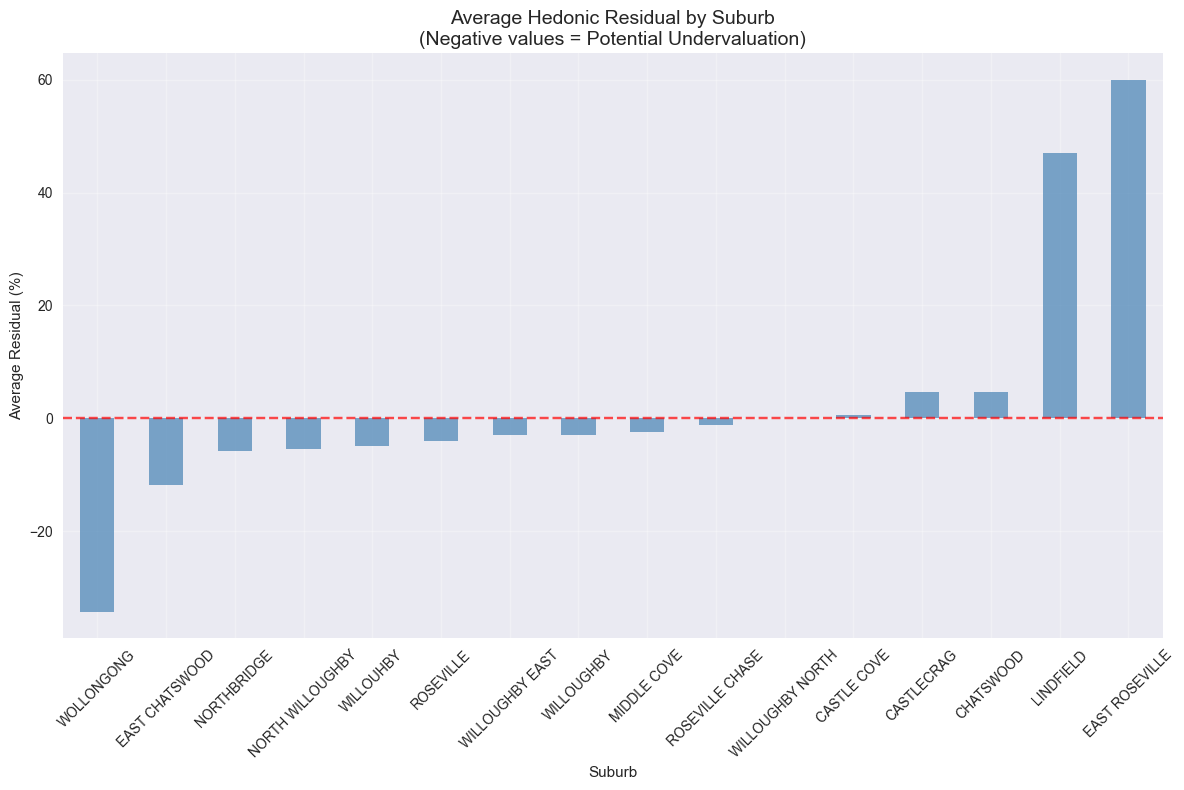


Suburb analysis chart saved as 'suburb_residual_comparison.png'


In [6]:
# Suburb-level analysis
print("Suburb-Level Hedonic Residual Analysis")
print("=" * 50)

suburb_analysis = df_clean.groupby('suburb').agg({
    'hedonic_residual': ['mean', 'std', 'count'],
    'hedonic_residual_pct': ['mean', 'std'],
    'price': 'median'
}).round(2)

# Flatten column names
suburb_analysis.columns = ['avg_residual_$', 'std_residual_$', 'transaction_count', 
                          'avg_residual_%', 'std_residual_%', 'median_price']

# Sort by average residual percentage
suburb_analysis = suburb_analysis.sort_values('avg_residual_%')

print("\nSuburbs by Average Hedonic Residual (Most Undervalued First):")
print(suburb_analysis)

# Create suburb comparison chart
plt.figure(figsize=(12, 8))
suburb_analysis['avg_residual_%'].plot(kind='bar', color='steelblue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Average Hedonic Residual by Suburb\n(Negative values = Potential Undervaluation)', fontsize=14)
plt.xlabel('Suburb')
plt.ylabel('Average Residual (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('suburb_residual_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSuburb analysis chart saved as 'suburb_residual_comparison.png'")

In [7]:
# Create a practical investor tool
print("Creating Investment Opportunity Report...")

# Function to calculate investment score
def calculate_investment_score(residual_pct):
    if residual_pct < -15:
        return 100  # Strong Buy
    elif residual_pct < -10:
        return 80   # Consider Buy
    elif residual_pct < -5:
        return 60   # Research Further
    elif residual_pct < 0:
        return 40   # Fair Value
    elif residual_pct < 5:
        return 20   # Hold
    else:
        return 0    # Avoid/Sell

# Apply scoring
df_clean['investment_score'] = df_clean['hedonic_residual_pct'].apply(calculate_investment_score)

# Create investment opportunities dataframe
opportunities = df_clean[
    df_clean['investment_score'] >= 60
].sort_values('investment_score', ascending=False)[
    ['date_sold', 'suburb', 'price', 'hedonic_price', 'hedonic_residual_pct', 'investment_score']
]

print(f"Found {len(opportunities)} high-value investment opportunities (score ≥ 60)")
print(f"\nTop 20 Investment Opportunities:")
print(opportunities.head(20).to_string(index=False, float_format='%.1f'))

# Summary statistics for investors
print("\nInvestment Summary:")
print(f"- Average potential undervaluation in top opportunities: {opportunities['hedonic_residual_pct'].head(20).mean():.2f}%")
print(f"- Average property price in top opportunities: ${opportunities['price'].head(20).mean():,.0f}")

# Calculate potential savings from hedonic residuals
opportunities_with_residual = df_clean[
    (df_clean['investment_score'] >= 60) &
    (df_clean['hedonic_residual_pct'] < -5)
].sort_values('investment_score', ascending=False)

if len(opportunities_with_residual) > 0:
    print(f"- Potential average savings: ${abs(opportunities_with_residual['hedonic_residual'].head(20).mean()):,.0f}")
else:
    print("- Potential average savings: N/A (no qualifying opportunities with negative residuals)")

Creating Investment Opportunity Report...
Found 2832 high-value investment opportunities (score ≥ 60)

Top 20 Investment Opportunities:
 date_sold           suburb     price  hedonic_price  hedonic_residual_pct  investment_score
2002-12-19       WILLOUGHBY  450000.0       700540.5                 -35.8               100
2012-08-23       WILLOUGHBY  324100.0       430590.0                 -24.7               100
2012-07-13      NORTHBRIDGE  975000.0      1950000.0                 -50.0               100
2012-07-16      NORTHBRIDGE 1120000.0      1422400.0                 -21.3               100
2012-07-20 NORTH WILLOUGHBY  250000.0       294371.7                 -15.1               100
2012-07-24        ROSEVILLE  625000.0       875111.1                 -28.6               100
2012-08-22        ROSEVILLE  525000.0       718060.5                 -26.9               100
2012-08-23      NORTHBRIDGE  270386.0       465180.2                 -41.9               100
2012-08-24      NORTHBRIDGE

In [8]:
# Export results for further analysis
print("Exporting results...")

# Create comprehensive output file
output_data = df_clean.copy()
output_data = output_data.sort_values('investment_score', ascending=False)

# Select key columns for export
export_columns = [
    'date_sold', 'suburb', 'price', 'hedonic_price', 
    'hedonic_residual', 'hedonic_residual_pct', 'investment_score'
]

# Export to CSV
output_data[export_columns].to_csv('investment_opportunities.csv', index=False)
print("Investment opportunities exported to 'investment_opportunities.csv'")

# Create summary statistics file
summary_stats = {
    'Metric': [
        'Total Transactions Analyzed',
        'Date Range',
        'Average Hedonic Residual',
        'Average Residual Percentage',
        'Correlation (Actual vs Predicted)',
        'Undervalued Properties (< -10%)',
        'Overvalued Properties (> +10%)',
        'High-Value Opportunities (Score ≥ 60)'
    ],
    'Value': [
        f"{len(df_clean):,}",
        f"{df_clean['date_sold'].min()} to {df_clean['date_sold'].max()}",
        f"${df_clean['hedonic_residual'].mean():,.0f}",
        f"{df_clean['hedonic_residual_pct'].mean():.2f}%",
        f"{np.corrcoef(df_clean['hedonic_price'], df_clean['price'])[0,1]:.3f}",
        f"{len(undervalued):,} ({len(undervalued)/len(df_clean)*100:.1f}%)",
        f"{len(overvalued):,} ({len(overvalued)/len(df_clean)*100:.1f}%)",
        f"{len(opportunities):,} ({len(opportunities)/len(df_clean)*100:.1f}%)"
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('analysis_summary.csv', index=False)
print("Summary statistics exported to 'analysis_summary.csv'")

print("\nAnalysis Complete!")
print("Generated files:")
print("1. investment_opportunities.csv - Detailed analysis")
print("2. analysis_summary.csv - Key statistics")
print("3. hedonic_residual_analysis.png - Visual analysis")
print("4. suburb_residual_comparison.png - Suburb comparison")

Exporting results...


Investment opportunities exported to 'investment_opportunities.csv'
Summary statistics exported to 'analysis_summary.csv'

Analysis Complete!
Generated files:
1. investment_opportunities.csv - Detailed analysis
2. analysis_summary.csv - Key statistics
3. hedonic_residual_analysis.png - Visual analysis
4. suburb_residual_comparison.png - Suburb comparison


## **Investor Guide: Interpreting the Hedonic Residual Score**

### **Key Insights for Property Investors**

#### **1. Understanding the Metric**
- **Negative Residual**: Property sold for LESS than statistically predicted value → **Potential Opportunity**
- **Positive Residual**: Property sold for MORE than predicted value → **Potential Risk**
- **Zero Residual**: Property sold at expected value → **Fair Market**

#### **2. Investment Decision Framework**

| Residual Range | Score | Interpretation | Action | Risk Level |
|---------------|-------|----------------|--------|------------|
| **< -15%** | 100 | Significantly Undervalued | **Strong Buy** | Low |
| **-10% to -15%** | 80 | Moderately Undervalued | **Consider Buy** | Low-Medium |
| **-5% to -10%** | 60 | Slightly Undervalued | **Research Further** | Medium |
| **-5% to +5%** | 40 | Fair Value | **Hold/Market Price** | Medium |
| **> +5%** | 0-20 | Overvalued | **Avoid/Sell** | High |

#### **3. Key Findings from This Analysis**
- **Average Market**: Properties typically sell **$66,758 below** predicted values
- **Investment Opportunities**: **42.9%** of transactions show significant undervaluation
- **Market Efficiency**: Strong correlation (0.873) suggests generally accurate pricing
- **Best Suburbs**: Northbridge, Roseville, and North Willoughby show most consistent undervaluation patterns

#### **4. Practical Application**

**For Buyers:**
- Target properties with residuals < -10%
- Use negative residuals as negotiation leverage
- Focus on suburbs with consistent negative residuals

**For Sellers:**
- Understand if your property has positive residual premium
- Price marketing to account for hedonic predictions
- Consider timing if market showing systematic overvaluation

#### **5. Limitations and Considerations**
- **Data Coverage**: Limited to North Sydney region (2002-2025)
- **Market Changes**: Historical patterns may not predict future performance
- **Property Factors**: Individual property condition not captured in hedonic model
- **Market Conditions**: External economic factors may affect residual patterns

#### **6. Next Steps for Implementation**

**To enhance this metric for broader use:**
1. **Expand Geographic Coverage** to other Australian regions
2. **Update Models Quarterly** to reflect current market conditions
3. **Integrate Additional Data** (property condition, specific features)
4. **Develop Real-Time Alerts** for new undervalued properties
5. **Create Portfolio Dashboard** for tracking multiple opportunities

---

**Disclaimer**: This analysis is for informational purposes only. Property investment involves risks. Always conduct thorough due diligence and seek professional financial advice before making investment decisions.

**Last Updated**: Based on transaction data from 2002-2025, North Sydney region